# Introduction

**Contents:** Produce additional results for the consumption-saving model

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from EconModel import jit
from ConSavModel import ConSavModelClass

# Consumption-Saving Model

In [2]:
model = ConSavModelClass()

In [3]:
par = model.par
sol = model.sol
sim = model.sim
D = sim.D_
Dbeg = sim.Dbeg_

In [4]:
model.solve(algo='egm')
model.prepare_simulate(algo='hist')
model.simulate_hist_alt()

iteration    0 solved in 2.0 secs   [max abs. diff. 4.96e+01]
iteration    1 solved in 0.0 secs   [max abs. diff. 1.67e+01]
iteration    2 solved in 0.0 secs   [max abs. diff. 8.35e+00]
iteration    3 solved in 0.0 secs   [max abs. diff. 5.02e+00]
iteration    4 solved in 0.0 secs   [max abs. diff. 3.35e+00]
iteration    5 solved in 0.0 secs   [max abs. diff. 2.39e+00]
iteration    6 solved in 0.0 secs   [max abs. diff. 1.80e+00]
iteration    7 solved in 0.0 secs   [max abs. diff. 1.40e+00]
iteration    8 solved in 0.0 secs   [max abs. diff. 1.12e+00]
iteration    9 solved in 0.0 secs   [max abs. diff. 9.15e-01]
iteration  100 solved in 0.0 secs   [max abs. diff. 3.28e-03]
iteration  200 solved in 0.0 secs   [max abs. diff. 3.03e-06]
iteration  269 solved in 0.0 secs   [max abs. diff. 9.93e-09]
model solved in 2.2 secs
model prepared for simulation in 0.0 secs
model simulated in 3.7 secs [271 iterations]


## Policy functions

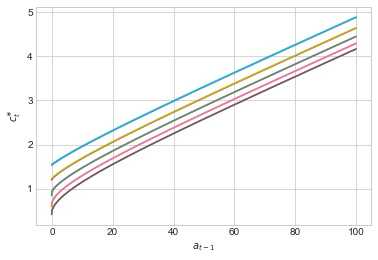

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i_z in range(par.Nz):
    ax.plot(par.a_grid,sol.c[i_z,:])
    
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$c_t^{\\ast}$');

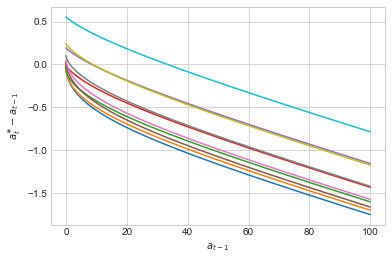

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i_z in range(par.Nz):
    ax.plot(par.a_grid,sol.a[i_z,:]-par.a_grid)
    
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$a_t^{\\ast}-a_{t-1}$');

## Savings distribution

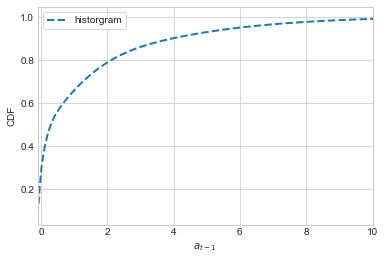

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

CDF = np.cumsum(np.sum(D,axis=(0,)))

ax.plot(par.a_grid,CDF,ls='--',lw=2,label='historgram')

ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('CDF')
ax.set_xlim([par.b,10.0])
ax.legend(frameon=True);

**Income moments:**

In [8]:
mean_z = np.sum(D*par.z_grid[:,np.newaxis])
std_z = np.sqrt(np.sum(D*(par.z_grid[:,np.newaxis]-mean_z)**2))
print(f'mean z: {mean_z:5.2f}')
print(f'std. z: {std_z:5.2f}')

mean z:  1.00
std. z:  0.38


**Asset moments**

In [9]:
# a. prepare
Da = np.sum(D,axis=0)
Da_cs = np.cumsum(Da)
mean_a = np.sum(Da*par.a_grid)
std_a = np.sqrt(np.sum(Da*(par.a_grid-mean_a)**2))

def percentile(par,Da_cs,p):
    
    # a. check first
    if p < Da_cs[0]: return par.a_grid[0]
    
    # b. find with loop
    i = 0
    while True:
        if p > Da_cs[i+1]:
            if i+1 >= par.Na: raise Exception()
            i += 1
            continue
        else:
            w = (p-Da_cs[i])/(Da_cs[i+1]-Da_cs[i])
            diff = par.a_grid[i+1]-par.a_grid[i]
            return par.a_grid[i]+w*diff
        
p25_a = percentile(par,Da_cs,0.25)
p50_a = percentile(par,Da_cs,0.50)
p95_a = percentile(par,Da_cs,0.95)
p99_a = percentile(par,Da_cs,0.99)

# b. print
print(f'mean a: {mean_a:6.3f}')
print(f'p25  a: {p25_a:6.3f}')
print(f'p50  a: {p50_a:6.3f}')
print(f'p95  a: {p95_a:6.3f}')
print(f'p99  a: {p99_a:6.3f}')
print(f'std. a: {std_a:6.3f}')

print(f'a = par.b: {Da[0]*100:.1f} %')
print(f'a <= 0: {np.sum(Da[par.a_grid <= 0])*100:.1f} %')

mean a:  1.272
p25  a: -0.014
p50  a:  0.298
p95  a:  5.969
p99  a:  9.824
std. a:  2.138
a = par.b: 8.1 %
a <= 0: 27.4 %


## MPCs

**Calculate MPC from consumption function:**

In [10]:
MPC = (sol.c[:,1:]-sol.c[:,:-1])/((1+par.r)*(par.a_grid[1:]-par.a_grid[:-1]))

**Policy function:**

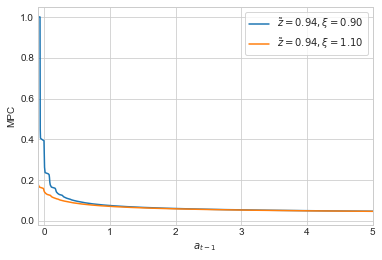

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i_zt in [par.Nzt//2]:
    for i_xi in [0,par.Nxi-1]:
    
        i_z = i_xi*par.Nzt + i_zt
        label = f'$\\tilde{{z}} = {par.zt_grid[i_zt]:.2f}, \\xi = {par.xi_grid[i_xi]:.2f}$'
        ax.plot(par.a_grid[:-1],MPC[i_z],label=label)

ax.set_xlim([par.b,5])
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('MPC')
ax.legend(frameon=True);

**Mean MPC:**

In [12]:
mean_MPC = np.sum(MPC*D[:,:-1])
print(f'mean MPC: {mean_MPC:6.3f}')

mean MPC:  0.202


**MPC distribution:**

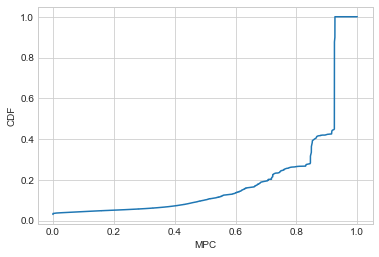

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

I = np.argsort(MPC.ravel())
ax.plot(np.cumsum(D[:,:-1].ravel()[I]),MPC.ravel()[I])

ax.set_xlabel('MPC')
ax.set_ylabel('CDF');

# The matrix formulation

**The stochastic transition, $\boldsymbol{D}_{t} =\Pi_{z}^{\prime}\underline{\boldsymbol{D}}_{t}$:**

In [14]:
@nb.njit
def build_Pi_z(par):

    Pi_z = np.zeros((par.Nz*par.Na,par.Nz*par.Na))

    i = 0
    for i_z_lag in range(par.Nz):
        for i_a_lag in range(par.Na):
            j = 0
            for i_z in range(par.Nz):
                for i_a_lag_ in range(par.Na):
                    if i_a_lag == i_a_lag_: # does not change
                        Pi_z[i,j] = par.z_trans[i_z_lag,i_z]                     
                    else:
                        Pi_z[i,j] = 0.0
                    j += 1
            i += 1
    
    return Pi_z
            

In [15]:
with jit(model) as model_jit:
    Pi_z = build_Pi_z(model_jit.par)

In [16]:
D_alt = Pi_z.T@Dbeg.ravel()
max_abs_diff = np.max(np.abs(D_alt-D.ravel()))
assert np.isclose(max_abs_diff,0.0)

**The choice transition, $\underline{\boldsymbol{D}}_{t+1} =\Lambda_{t}^{\prime}\boldsymbol{D}_{t}$:**

In [17]:
@nb.njit
def build_Lambda(par,sol):

    Lambda = np.zeros((par.Nz*par.Na,par.Nz*par.Na))

    i = 0
    for i_z in range(par.Nz):
        for i_a_lag in range(par.Na):
            j = 0
            for i_z_ in range(par.Nz):
                for i_a in range(par.Na):
                    if i_z == i_z_ and i_a == sol.pol_indices[i_z,i_a_lag]:
                        Lambda[i,j] = sol.pol_weights[i_z,i_a_lag]
                    elif i_z == i_z_ and i_a == sol.pol_indices[i_z,i_a_lag]+1:
                        Lambda[i,j] = 1-sol.pol_weights[i_z,i_a_lag]
                    else:
                        Lambda[i,j] = 0.0
                    j += 1
            i += 1
     
    return Lambda

In [18]:
with jit(model) as model_jit:
    Lambda = build_Lambda(model_jit.par,model_jit.sol)

In [19]:
Dbeg_plus_alt = Lambda.T@D.ravel()
max_abs_diff = np.max(np.abs(Dbeg_plus_alt-Dbeg.ravel()))
assert np.isclose(max_abs_diff,0.0)

# Auto-correlation of savings over time

In [20]:
from ConSavModel import simulate_hh_forwards_stochastic,simulate_hh_forwards_choice

In [21]:
@nb.njit
def autocorr(par,sol,D,max_k):
    
    autocorr_vec = np.zeros(max_k)
    
    # a. mean and variance
    Da = np.sum(D,axis=0)
    mean_a = np.sum(Da*par.a_grid)
    var_a = np.sum(Da*(par.a_grid-mean_a)**2)
    
    # b. covariance
    Dbeg = np.zeros(D.shape)
    for i_z in range(par.Nz):
        for i_a_lag in range(par.Na):
            
            if D[i_z,i_a_lag] < 1e-12: continue
            
            D_fut = np.zeros(D.shape)
            D_fut[i_z,i_a_lag] = 1.0
            
            for k in range(max_k):
                
                simulate_hh_forwards_choice(par,sol,D_fut,Dbeg)
                simulate_hh_forwards_stochastic(par,Dbeg,D_fut)
                
                autocorr_vec[k] += D[i_z,i_a_lag]*np.sum( (par.a_grid[i_a_lag]-mean_a)*(par.a_grid-mean_a)*D_fut )
                                         
    return autocorr_vec/var_a

In [22]:
with jit(model) as model_jit:
    autocorr_vec = autocorr(model_jit.par,model_jit.sol,D,1)

print(f'autocorr(a_t,a_t+1) = {autocorr_vec[0]:6.3f}')

autocorr(a_t,a_t+1) =  0.998


In [23]:
with jit(model) as model_jit:
    %time autocorr_vec = autocorr(model_jit.par,model_jit.sol,D,1)
    %time autocorr_vec = autocorr(model_jit.par,model_jit.sol,D,5)

Wall time: 415 ms
Wall time: 3.54 s


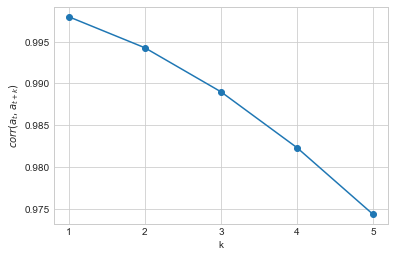

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(np.arange(1,6),autocorr_vec,'-o')

ax.set_xticks(np.arange(1,6))
ax.set_xlabel('k')
ax.set_ylabel('$corr(a_t,a_{t+k})$');

**Note:** The long auto-correlations are computionally expensive to compute with the histogram method. See [Computing Longitudinal Moments for
Heterogeneous Agent Models](https://github.com/ocamp020/Histogram_Iteration) for additional details.